In [ ]:
# -*- coding: utf-8 -*-
"""
Neuromorphic Setup (Nonlinear Transformation from Linear Wave Scattering)

Code for training a neuromorphic device implementing nonlinear
information processing via the parameter dependence of the
scattering matrix.

Attributes implemented here (see manuscript):
- Transmission Setup
- Fully Connected Structure
- Data set: Fashion MNIST

Requirements: jax, optax, tensorflow [only for data loading]

Train the parameters in a scattering matrix using jax.

NOTE:
Directory 'outputs' needs to exist in the current directory!

C. Wanjura and F. Marquardt
2023/24, MIT License
"""

In [ ]:
## NOTE: all physical parameters are expressed in units of the uniform decay rate kappa

In [ ]:
## Import necessary libraries
import os

import numpy as np
from numpy import loadtxt

import time

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jit, vmap, grad
from jax.scipy.linalg import expm
from jax import random

## key for random number generation with jax
key = random.PRNGKey(0)

load data

In [ ]:
lines = loadtxt("optdigits.tra", comments="#", delimiter=",", unpack=False)
lines_test = loadtxt("optdigits.tes", comments="#", delimiter=",", unpack=False)

In [ ]:
## rescale image data: white pixles (background) are set to a detuning of 5, black pixels (foreground, numerals) are set to a detuning of 0 (resonant)

## training images
x_train_vect = jnp.complex64(jnp.array(5*(1 - (lines[:,0:64])/16)))
y_train = np.array(lines[:,64], dtype = int)
y_train_vect = jnp.zeros((len(lines),10))
for jj in range(len(y_train)):
    y_train_vect = y_train_vect.at[jj, int(y_train[jj])].set(1.0)
y_train_vect = jnp.complex64(y_train_vect)

## test images
x_test_vect = jnp.complex64(jnp.array(5*(1 - (lines_test[:,0:64])/16)))
y_test = np.array(lines_test[:,64], dtype = int)
y_test_vect = jnp.zeros((len(lines_test),10))
for jj in range(len(y_test)):
    y_test_vect = y_test_vect.at[jj, int(y_test[jj])].set(1.0)
y_test_vect = jnp.complex64(y_test_vect)

setup neuromorphic system

In [ ]:
## susceptibility matrices and the inverse of susceptibility matrices (in the paper referred to as G_n in Eqs. (12) to (15))
## omega corresponds to the detuning \Delta (note: the sign in front of omega here is arbitrary since these are trained parameters allowing for both positive and negative values)

def invSuscept(gamma, omega):
  return jnp.diag(-gamma/2 + 1j*omega)

def suscept(gamma, omega):
  return jnp.diag(1/(-gamma/2 + 1j*omega))

# omega0 will later encode the input data
def susceptLayer0(gamma, omega, omega0):
  return jnp.diag(1/(-gamma/2 - 1j*omega - 1j*omega0))

In [ ]:
## functions to generate vectors (to initialise detunings) or matrices (to initialise coupling matrices) of real random numbers
## Nj refers the size of the jth layer

## uniform distribution between 0 and 1
def randomVector(subkey, Nj):
  return jnp.complex64(random.uniform(subkey, shape=(Nj,)))

def randomJJ(subkey, N1, N2):
  return jnp.complex64(random.uniform(subkey, shape=(N1,N2)))

## Gaussian distribution 
def randomVectorGauss(Nj):
  return np.complex64(np.random.normal(0, 5, size = (Nj,)))

def randomJJGauss(N1, N2):
  return np.complex64(np.random.normal(0, 5, size = (N1,N2)))

In [ ]:
''''
This function calculates the output of the neuromorphic system according to the
definition of the scattering matrix in Eq. (15) of the paper.

We consider a three-layer network. Physical quantities are indexed according to the layer (0 to 2).

We use the following notation:

x : vector of input data
x_tmp : vector of input data in which data is replicated R times (input replication)
xVect : vector of replicated input data + initial detuning offsets

layer0 : G_0 in Eqs. (12) to (15)
layer1 : G_1
layer2 : G_2 (the output layer)

gamma0, gamma1, gamma2 : decay rates in layers 0, 1 and 2 (later considered uniform in the system)
omega0 : detuning off-set in layer 0 (in which also the data input enters)
omega1, omega2: detunings in layers 1 and 2

JJ0 : coupling matrix between layer 0 and layer 1
JJ1 : coupling matrix between layer 1 and 2
''''

def network(x, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2):
  x_tmp = jnp.repeat(x, 2) ## input replication is 2
  xVect = x_tmp + omega0
  layer0 = susceptLayer0(gamma0, xVect, omega0)
  layer1 = jnp.linalg.inv(invSuscept(gamma1, omega1) + jnp.matmul(jnp.matmul(jnp.conjugate(jnp.transpose(JJ0)), layer0), JJ0))
  layer2 = jnp.linalg.inv(invSuscept(gamma2, omega2) + jnp.matmul(jnp.matmul(jnp.conjugate(jnp.transpose(JJ1)), layer1), JJ1))
  return jnp.diag(jnp.identity(len(gamma2)) + jnp.matmul(jnp.matmul(jnp.diag(jnp.sqrt(gamma2)), layer2), jnp.diag(jnp.sqrt(gamma2))))

network_jit = jax.jit(network)

In [ ]:
## categorical cross-entropy cost function

## x: input, y: output to be learned

def costF(x, y, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2):
  prob = jnp.log(jax.nn.softmax(8 * jnp.imag(network(x, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2))))
  return - jnp.dot(prob, y)

## evaluate cost function over entire batch/ training set
def costF_vmap(x, y, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2):
  return jnp.mean(vmap(costF, in_axes = (0,0,None,None,None,None,None,None,None,None), out_axes=0)(x, y, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2),axis=0)

## function returns gradient of averaged cost function
## differentiates w.r.t. JJ0, JJ1, omega0, omega1, omega2
def costF_grad_all_mean(x, y, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2):
  return grad(costF_vmap, argnums=[2,3,7,8,9], holomorphic=True)(x, y, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)

costF_grad_all_mean_jit = jax.jit(costF_grad_all_mean)

## function returns gradient of averaged cost function as well as the average value of the cost function
## differentiates w.r.t. JJ0, JJ1, omega0, omega1, omega2
def costF_value_and_grad_all_mean(x, y, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2):
  return jax.value_and_grad(costF_vmap, argnums=[2,3,7,8,9], holomorphic=True)(x, y, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)

costF_value_and_grad_all_mean_jit = jax.jit(costF_value_and_grad_all_mean)

training for hidden layer size 80

In [ ]:
## initialise

'''' layer sizes:
N0 = R * input_dimensions
N1 : hidden layer size
N2 = 10 (output dimension)
''''

N0 = 2*64
N1 = 80
N2 = 10

gamma_max = 1.0

## keys and subkeys for jax random number generator
key, subkey1 = random.split(key)
key, subkey2 = random.split(key)
key, subkey3 = random.split(key)
key, subkey4 = random.split(key)
key, subkey5 = random.split(key)
key, subkey6 = random.split(key)
key, subkey7 = random.split(key)
key, subkey8 = random.split(key)

## detuning off-sets initially alternate between +2 and -2
omega0 = np.empty((N0,),int)
omega0[::2] = 2
omega0[1::2] = -2
omega0 = jnp.complex64(omega0 * gamma_max)

## uniform decay
gamma0 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N0))[0])
gamma1 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N1))[0])
gamma2 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N2))[0])

## initialise detunings in hidden layer and output layer
## empirical observation: initialising with small, positive values leads to faster convergence and better performance (for this data set)
omega1 = jnp.complex64(jnp.zeros((1,N1))[0]) + 0.001 * jnp.complex64(randomVector(subkey1, N1))
omega2 = jnp.complex64(jnp.zeros((1,N2))[0]) + 0.001 * jnp.complex64(randomVector(subkey3, N2))

## initialise coupling matrices to kappa + 0.1 * xi (with xi a random number between 0 and 1)
JJ0 = gamma_max * jnp.complex64(jnp.ones((N0,N1))) + 0.1 * jnp.complex64(randomJJ(subkey4, N0, N1))
JJ1 = gamma_max * jnp.complex64(jnp.ones((N1,N2))) + 0.1 * jnp.complex64(randomJJ(subkey5, N1, N2))

In [ ]:
''''
acc_classif_train : stores training accuracy
acc_classif_test : stores test accuracy
prec : stores cost function
''''

acc_classif_train = jnp.array([])
acc_classif_test = jnp.array([])
prec = jnp.array([])

number_epochs = 5000

In [ ]:
learning_rate = 20*1e-2
batch_size = 200

## x_train_vect is not divisible by 200
## need to handle last minibatch of epoch separately
iterations_per_batch = int(len(x_train_vect) / batch_size)
last_step = True ## true after the last step of the epoch has been performed and the remaining samples have been taken care of

## 19 steps correspond to one epoch (the last step handles the smaller mini-batch )
for j in range(19 * number_epochs):

    ## first step after an epoch has been evaluated
    if (j % iterations_per_batch == 0) and last_step:
        random_mix_2 = np.random.choice(len(x_train_vect), len(x_train_vect), replace = False)
        last_setp = False
  
    ## at the end of an epoch evaluate the mini-batch with the remaining samples
    if (j % iterations_per_batch == 0) and not last_step:
        batch_subset = random_mix_2[iterations_per_batch * batch_size : ]
        last_step = True ## this was the last set of the epoch
        j -= 1
    else:
        batch_subset = random_mix_2[(j % iterations_per_batch) * batch_size : (j % iterations_per_batch+1) * batch_size]
  
    #batch_subset = np.random.choice(len(x_train_vect), batch_size, replace = False)
    x_minibatch = x_train_vect[batch_subset]
    y_minibatch = y_train_vect[batch_subset]

    prec_val, [JJ0_grad, JJ1_grad, omega0_grad, omega1_grad, omega2_grad] = costF_value_and_grad_all_mean_jit(x_minibatch, y_minibatch, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)

    JJ0 -= learning_rate * jnp.complex64(jnp.real(JJ0_grad))
    JJ1 -= learning_rate * jnp.complex64(jnp.real(JJ1_grad))
    omega0 -= learning_rate * jnp.complex64(jnp.real(omega0_grad))
    omega1 -= learning_rate * jnp.complex64(jnp.real(omega1_grad))
    omega2 -= learning_rate * jnp.complex64(jnp.real(omega2_grad))

    prec = jnp.append(prec, jnp.real(prec_val))
    
    if j % 60 == 0: ## every 3 epochs
        out_network = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_train_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))
        out_network = out_network.reshape(len(x_train_vect), 10)
        acc_classif_train = jnp.append(acc_classif_train, sum(jnp.argmax(out_network, axis = 1) == y_train)/len(x_train_vect) )

        out_network_test = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_test_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))
        out_network_test = out_network_test.reshape(len(x_test_vect), 10)
        acc_classif_test = jnp.append(acc_classif_test, sum(jnp.argmax(out_network_test, axis = 1) == y_test)/len(x_test_vect) )

  
    ## save all system parameters after one epoch
    ## comment out to save disk space
    if last_step or (j == 0):
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_JJ0.csv", JJ0, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_JJ1.csv", JJ1, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega0.csv", omega0, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega1.csv", omega1, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega2.csv", omega2, delimiter=",")

out_network = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_train_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))

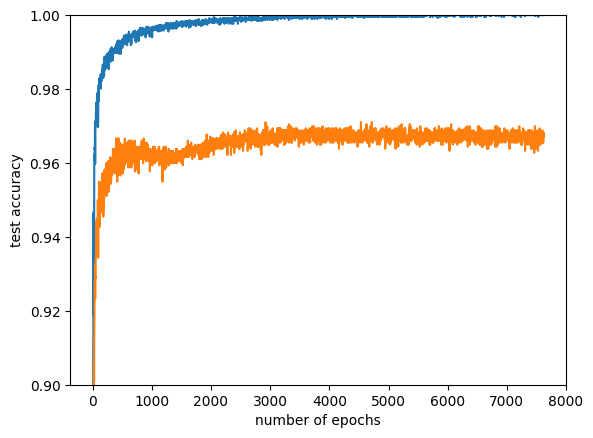

In [ ]:
plt.ylabel('test accuracy')
plt.xlabel('number of epochs')
plt.ylim([.9,1])

plt.plot(jnp.arange(1,3*len(acc_classif_train),3), acc_classif_train)
plt.plot(jnp.arange(1,3*len(acc_classif_test),3), acc_classif_test)

In [ ]:
np.max(acc_classif_test)

Array(0.9710629, dtype=float32)

In [ ]:
np.max(acc_classif_train)

Array(1., dtype=float32)

In [ ]:
np.savetxt("N2=80_accuracy_test.csv", acc_classif_test, delimiter=",")

In [ ]:
np.savetxt("N2=80_accuracy_training.csv", acc_classif_train, delimiter=",")

In [ ]:
np.savetxt("N2=80_costfunction.csv", prec, delimiter=",")

training for hidden layer size 60

In [ ]:
## initialise

'''' layer sizes:
N0 = R * input_dimensions
N1 : hidden layer size
N2 = 10 (output dimension)
''''

N0 = 2*64
N1 = 60
N2 = 10

gamma_max = 1.0

## keys and subkeys for jax random number generator
key, subkey1 = random.split(key)
key, subkey2 = random.split(key)
key, subkey3 = random.split(key)
key, subkey4 = random.split(key)
key, subkey5 = random.split(key)
key, subkey6 = random.split(key)
key, subkey7 = random.split(key)
key, subkey8 = random.split(key)

## detuning off-sets initially alternate between +2 and -2
omega0 = np.empty((N0,),int)
omega0[::2] = 2
omega0[1::2] = -2
omega0 = jnp.complex64(omega0 * gamma_max)

## uniform decay
gamma0 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N0))[0])
gamma1 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N1))[0])
gamma2 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N2))[0])

## initialise detunings in hidden layer and output layer
## empirical observation: initialising with small, positive values leads to faster convergence and better performance (for this data set)
omega1 = jnp.complex64(jnp.zeros((1,N1))[0]) + 0.001 * jnp.complex64(randomVector(subkey1, N1))
omega2 = jnp.complex64(jnp.zeros((1,N2))[0]) + 0.001 * jnp.complex64(randomVector(subkey3, N2))

## initialise coupling matrices to kappa + 0.1 * xi (with xi a random number between 0 and 1)
JJ0 = gamma_max * jnp.complex64(jnp.ones((N0,N1))) + 0.1 * jnp.complex64(randomJJ(subkey4, N0, N1))
JJ1 = gamma_max * jnp.complex64(jnp.ones((N1,N2))) + 0.1 * jnp.complex64(randomJJ(subkey5, N1, N2))

In [ ]:
''''
acc_classif_train : stores training accuracy
acc_classif_test : stores test accuracy
prec : stores cost function
''''

acc_classif_train = jnp.array([])
acc_classif_test = jnp.array([])
prec = jnp.array([])

number_epochs = 5000

In [ ]:
learning_rate = 20*1e-2
batch_size = 200

## x_train_vect is not divisible by 200
## need to handle last minibatch of epoch separately
iterations_per_batch = int(len(x_train_vect) / batch_size)
last_step = True ## true after the last step of the epoch has been performed and the remaining samples have been taken care of

## 19 steps correspond to one epoch (the last step handles the smaller mini-batch )
for j in range(19 * number_epochs):

    ## first step after an epoch has been evaluated
    if (j % iterations_per_batch == 0) and last_step:
        random_mix_2 = np.random.choice(len(x_train_vect), len(x_train_vect), replace = False)
        last_setp = False
  
    ## at the end of an epoch evaluate the mini-batch with the remaining samples
    if (j % iterations_per_batch == 0) and not last_step:
        batch_subset = random_mix_2[iterations_per_batch * batch_size : ]
        last_step = True ## this was the last set of the epoch
        j -= 1
    else:
        batch_subset = random_mix_2[(j % iterations_per_batch) * batch_size : (j % iterations_per_batch+1) * batch_size]
  
    #batch_subset = np.random.choice(len(x_train_vect), batch_size, replace = False)
    x_minibatch = x_train_vect[batch_subset]
    y_minibatch = y_train_vect[batch_subset]

    prec_val, [JJ0_grad, JJ1_grad, omega0_grad, omega1_grad, omega2_grad] = costF_value_and_grad_all_mean_jit(x_minibatch, y_minibatch, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)

    JJ0 -= learning_rate * jnp.complex64(jnp.real(JJ0_grad))
    JJ1 -= learning_rate * jnp.complex64(jnp.real(JJ1_grad))
    omega0 -= learning_rate * jnp.complex64(jnp.real(omega0_grad))
    omega1 -= learning_rate * jnp.complex64(jnp.real(omega1_grad))
    omega2 -= learning_rate * jnp.complex64(jnp.real(omega2_grad))

    prec = jnp.append(prec, jnp.real(prec_val))
    
    if j % 60 == 0: ## every 3 epochs
        out_network = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_train_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))
        out_network = out_network.reshape(len(x_train_vect), 10)
        acc_classif_train = jnp.append(acc_classif_train, sum(jnp.argmax(out_network, axis = 1) == y_train)/len(x_train_vect) )

        out_network_test = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_test_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))
        out_network_test = out_network_test.reshape(len(x_test_vect), 10)
        acc_classif_test = jnp.append(acc_classif_test, sum(jnp.argmax(out_network_test, axis = 1) == y_test)/len(x_test_vect) )

  
    ## save all system parameters after one epoch
    ## comment out to save disk space
    if last_step or (j == 0):
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_JJ0.csv", JJ0, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_JJ1.csv", JJ1, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega0.csv", omega0, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega1.csv", omega1, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega2.csv", omega2, delimiter=",")

out_network = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_train_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))

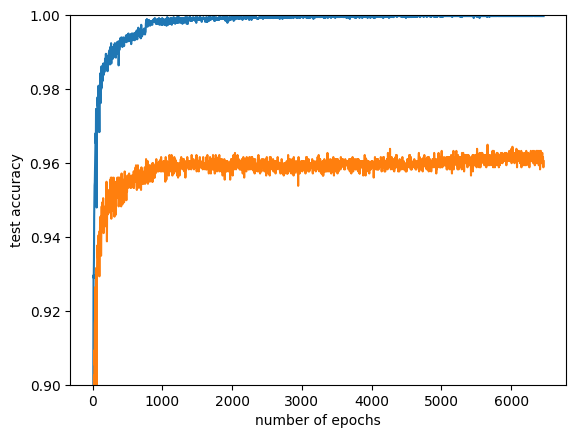

In [ ]:
plt.ylabel('test accuracy')
plt.xlabel('number of epochs')
plt.ylim([.9,1])

plt.plot(jnp.arange(1,3*len(acc_classif_train),3), acc_classif_train)
plt.plot(jnp.arange(1,3*len(acc_classif_test),3), acc_classif_test)

In [ ]:
np.max(acc_classif_test)

Array(0.96215916, dtype=float32)

In [ ]:
np.max(acc_classif_train)

Array(1., dtype=float32)

In [ ]:
np.savetxt("N2=60_accuracy_test_run2.csv", acc_classif_test, delimiter=",")

In [ ]:
np.savetxt("N2=60_accuracy_training_run2.csv", acc_classif_train, delimiter=",")

In [ ]:
np.savetxt("N2=60_costfunction_run2.csv", prec, delimiter=",")

trainining for hidden layer size 30

In [ ]:
## initialise

'''' layer sizes:
N0 = R * input_dimensions
N1 : hidden layer size
N2 = 10 (output dimension)
''''

N0 = 2*64
N1 = 30
N2 = 10

gamma_max = 1.0

## keys and subkeys for jax random number generator
key, subkey1 = random.split(key)
key, subkey2 = random.split(key)
key, subkey3 = random.split(key)
key, subkey4 = random.split(key)
key, subkey5 = random.split(key)
key, subkey6 = random.split(key)
key, subkey7 = random.split(key)
key, subkey8 = random.split(key)

## detuning off-sets initially alternate between +2 and -2
omega0 = np.empty((N0,),int)
omega0[::2] = 2
omega0[1::2] = -2
omega0 = jnp.complex64(omega0 * gamma_max)

## uniform decay
gamma0 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N0))[0])
gamma1 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N1))[0])
gamma2 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N2))[0])

## initialise detunings in hidden layer and output layer
## empirical observation: initialising with small, positive values leads to faster convergence and better performance (for this data set)
omega1 = jnp.complex64(jnp.zeros((1,N1))[0]) + 0.001 * jnp.complex64(randomVector(subkey1, N1))
omega2 = jnp.complex64(jnp.zeros((1,N2))[0]) + 0.001 * jnp.complex64(randomVector(subkey3, N2))

## initialise coupling matrices to kappa + 0.1 * xi (with xi a random number between 0 and 1)
JJ0 = gamma_max * jnp.complex64(jnp.ones((N0,N1))) + 0.1 * jnp.complex64(randomJJ(subkey4, N0, N1))
JJ1 = gamma_max * jnp.complex64(jnp.ones((N1,N2))) + 0.1 * jnp.complex64(randomJJ(subkey5, N1, N2))

In [ ]:
''''
acc_classif_train : stores training accuracy
acc_classif_test : stores test accuracy
prec : stores cost function
''''

acc_classif_train = jnp.array([])
acc_classif_test = jnp.array([])
prec = jnp.array([])

number_epochs = 5000

In [ ]:
learning_rate = 20*1e-2
batch_size = 200

## x_train_vect is not divisible by 200
## need to handle last minibatch of epoch separately
iterations_per_batch = int(len(x_train_vect) / batch_size)
last_step = True ## true after the last step of the epoch has been performed and the remaining samples have been taken care of

## 19 steps correspond to one epoch (the last step handles the smaller mini-batch )
for j in range(19 * number_epochs):

    ## first step after an epoch has been evaluated
    if (j % iterations_per_batch == 0) and last_step:
        random_mix_2 = np.random.choice(len(x_train_vect), len(x_train_vect), replace = False)
        last_setp = False
  
    ## at the end of an epoch evaluate the mini-batch with the remaining samples
    if (j % iterations_per_batch == 0) and not last_step:
        batch_subset = random_mix_2[iterations_per_batch * batch_size : ]
        last_step = True ## this was the last set of the epoch
        j -= 1
    else:
        batch_subset = random_mix_2[(j % iterations_per_batch) * batch_size : (j % iterations_per_batch+1) * batch_size]
  
    #batch_subset = np.random.choice(len(x_train_vect), batch_size, replace = False)
    x_minibatch = x_train_vect[batch_subset]
    y_minibatch = y_train_vect[batch_subset]

    prec_val, [JJ0_grad, JJ1_grad, omega0_grad, omega1_grad, omega2_grad] = costF_value_and_grad_all_mean_jit(x_minibatch, y_minibatch, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)

    JJ0 -= learning_rate * jnp.complex64(jnp.real(JJ0_grad))
    JJ1 -= learning_rate * jnp.complex64(jnp.real(JJ1_grad))
    omega0 -= learning_rate * jnp.complex64(jnp.real(omega0_grad))
    omega1 -= learning_rate * jnp.complex64(jnp.real(omega1_grad))
    omega2 -= learning_rate * jnp.complex64(jnp.real(omega2_grad))

    prec = jnp.append(prec, jnp.real(prec_val))
    
    if j % 60 == 0: ## every 3 epochs
        out_network = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_train_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))
        out_network = out_network.reshape(len(x_train_vect), 10)
        acc_classif_train = jnp.append(acc_classif_train, sum(jnp.argmax(out_network, axis = 1) == y_train)/len(x_train_vect) )

        out_network_test = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_test_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))
        out_network_test = out_network_test.reshape(len(x_test_vect), 10)
        acc_classif_test = jnp.append(acc_classif_test, sum(jnp.argmax(out_network_test, axis = 1) == y_test)/len(x_test_vect) )

  
    ## save all system parameters after one epoch
    ## comment out to save disk space
    if last_step or (j == 0):
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_JJ0.csv", JJ0, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_JJ1.csv", JJ1, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega0.csv", omega0, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega1.csv", omega1, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega2.csv", omega2, delimiter=",")

out_network = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_train_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))

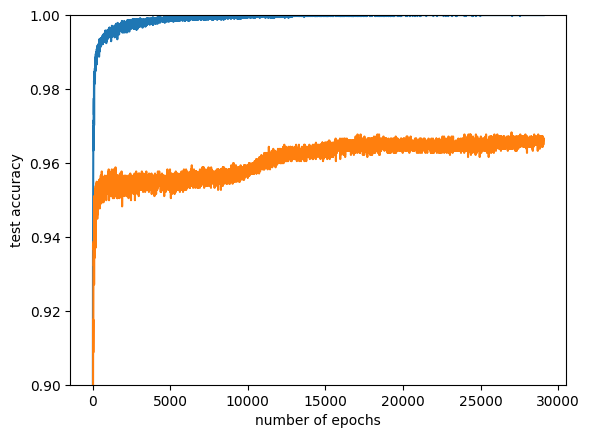

In [ ]:
plt.ylabel('test accuracy')
plt.xlabel('number of epochs')
plt.ylim([.9,1])

plt.plot(jnp.arange(1,3*len(acc_classif_train),3), acc_classif_train)
plt.plot(jnp.arange(1,3*len(acc_classif_test),3), acc_classif_test)

In [ ]:
np.max(acc_classif_test)

Array(0.9682805, dtype=float32)

In [ ]:
np.max(acc_classif_train)

Array(1., dtype=float32)

In [ ]:
np.savetxt("N2=30_accuracy_test_run3.csv", acc_classif_test, delimiter=",")

In [ ]:
np.savetxt("N2=30_accuracy_training_run3.csv", acc_classif_train, delimiter=",")

In [ ]:
np.savetxt("N2=30_costfunction_run3.csv", prec, delimiter=",")

training for hidden layer size 20

In [ ]:
## initialise

'''' layer sizes:
N0 = R * input_dimensions
N1 : hidden layer size
N2 = 10 (output dimension)
''''

N0 = 2*64
N1 = 20
N2 = 10

gamma_max = 1.0

## keys and subkeys for jax random number generator
key, subkey1 = random.split(key)
key, subkey2 = random.split(key)
key, subkey3 = random.split(key)
key, subkey4 = random.split(key)
key, subkey5 = random.split(key)
key, subkey6 = random.split(key)
key, subkey7 = random.split(key)
key, subkey8 = random.split(key)

## detuning off-sets initially alternate between +2 and -2
omega0 = np.empty((N0,),int)
omega0[::2] = 2
omega0[1::2] = -2
omega0 = jnp.complex64(omega0 * gamma_max)

## uniform decay
gamma0 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N0))[0])
gamma1 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N1))[0])
gamma2 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N2))[0])

## initialise detunings in hidden layer and output layer
## empirical observation: initialising with small, positive values leads to faster convergence and better performance (for this data set)
omega1 = jnp.complex64(jnp.zeros((1,N1))[0]) + 0.001 * jnp.complex64(randomVector(subkey1, N1))
omega2 = jnp.complex64(jnp.zeros((1,N2))[0]) + 0.001 * jnp.complex64(randomVector(subkey3, N2))

## initialise coupling matrices to kappa + 0.1 * xi (with xi a random number between 0 and 1)
JJ0 = gamma_max * jnp.complex64(jnp.ones((N0,N1))) + 0.1 * jnp.complex64(randomJJ(subkey4, N0, N1))
JJ1 = gamma_max * jnp.complex64(jnp.ones((N1,N2))) + 0.1 * jnp.complex64(randomJJ(subkey5, N1, N2))

In [ ]:
''''
acc_classif_train : stores training accuracy
acc_classif_test : stores test accuracy
prec : stores cost function
''''

acc_classif_train = jnp.array([])
acc_classif_test = jnp.array([])
prec = jnp.array([])

number_epochs = 5000

In [ ]:
learning_rate = 20*1e-2
batch_size = 200

## x_train_vect is not divisible by 200
## need to handle last minibatch of epoch separately
iterations_per_batch = int(len(x_train_vect) / batch_size)
last_step = True ## true after the last step of the epoch has been performed and the remaining samples have been taken care of

## 19 steps correspond to one epoch (the last step handles the smaller mini-batch )
for j in range(19 * number_epochs):

    ## first step after an epoch has been evaluated
    if (j % iterations_per_batch == 0) and last_step:
        random_mix_2 = np.random.choice(len(x_train_vect), len(x_train_vect), replace = False)
        last_setp = False
  
    ## at the end of an epoch evaluate the mini-batch with the remaining samples
    if (j % iterations_per_batch == 0) and not last_step:
        batch_subset = random_mix_2[iterations_per_batch * batch_size : ]
        last_step = True ## this was the last set of the epoch
        j -= 1
    else:
        batch_subset = random_mix_2[(j % iterations_per_batch) * batch_size : (j % iterations_per_batch+1) * batch_size]
  
    #batch_subset = np.random.choice(len(x_train_vect), batch_size, replace = False)
    x_minibatch = x_train_vect[batch_subset]
    y_minibatch = y_train_vect[batch_subset]

    prec_val, [JJ0_grad, JJ1_grad, omega0_grad, omega1_grad, omega2_grad] = costF_value_and_grad_all_mean_jit(x_minibatch, y_minibatch, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)

    JJ0 -= learning_rate * jnp.complex64(jnp.real(JJ0_grad))
    JJ1 -= learning_rate * jnp.complex64(jnp.real(JJ1_grad))
    omega0 -= learning_rate * jnp.complex64(jnp.real(omega0_grad))
    omega1 -= learning_rate * jnp.complex64(jnp.real(omega1_grad))
    omega2 -= learning_rate * jnp.complex64(jnp.real(omega2_grad))

    prec = jnp.append(prec, jnp.real(prec_val))
    
    if j % 60 == 0: ## every 3 epochs
        out_network = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_train_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))
        out_network = out_network.reshape(len(x_train_vect), 10)
        acc_classif_train = jnp.append(acc_classif_train, sum(jnp.argmax(out_network, axis = 1) == y_train)/len(x_train_vect) )

        out_network_test = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_test_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))
        out_network_test = out_network_test.reshape(len(x_test_vect), 10)
        acc_classif_test = jnp.append(acc_classif_test, sum(jnp.argmax(out_network_test, axis = 1) == y_test)/len(x_test_vect) )

  
    ## save all system parameters after one epoch
    ## comment out to save disk space
    if last_step or (j == 0):
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_JJ0.csv", JJ0, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_JJ1.csv", JJ1, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega0.csv", omega0, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega1.csv", omega1, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega2.csv", omega2, delimiter=",")

out_network = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_train_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))

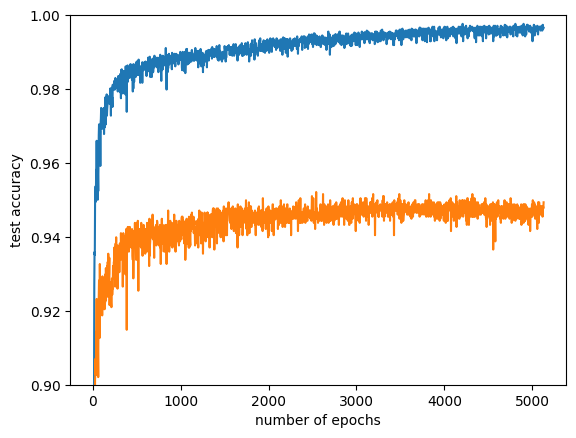

In [ ]:
plt.ylabel('test accuracy')
plt.xlabel('number of epochs')
plt.ylim([.9,1])

plt.plot(jnp.arange(1,3*len(acc_classif_train),3), acc_classif_train)
plt.plot(jnp.arange(1,3*len(acc_classif_test),3), acc_classif_test)

In [ ]:
np.max(acc_classif_test)

Array(0.9521425, dtype=float32)

In [ ]:
np.max(acc_classif_train)

Array(0.99764585, dtype=float32)

In [ ]:
np.savetxt("N2=20_accuracy_test.csv", acc_classif_test, delimiter=",")

In [ ]:
np.savetxt("N2=20_accuracy_training.csv", acc_classif_train, delimiter=",")

In [ ]:
np.savetxt("N2=20_costfunction.csv", prec, delimiter=",")

neuromorphic system without a hidden layer

In [ ]:
'''' function calculates the output of the neuromorphic system without a hidden layer: the diagonal of the scattering matrix in Eq. (15)
NOTE: JJ1 and omega2 are not used
    (they are merely placeholders to keep the number of arguments in the function 'network' the same so that the same
    functions for the computation of the cost function and gradients can be used)
''''

def network(x, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2):
  x_tmp = jnp.repeat(x, 2)
  xVect = x_tmp + omega0
  layer0 = susceptLayer0(gamma0, xVect, omega0)
  layer1 = jnp.linalg.inv(invSuscept(gamma1, omega1) + jnp.matmul(jnp.matmul(jnp.conjugate(jnp.transpose(JJ0)), layer0), JJ0))
  return jnp.diag(jnp.identity(len(gamma2)) + jnp.matmul(jnp.matmul(jnp.diag(jnp.sqrt(gamma2)), layer1), jnp.diag(jnp.sqrt(gamma2))))

network_jit = jax.jit(network)

In [ ]:
## initialise

'''' layer sizes:
N0 = R * input_dimensions
N1 : hidden layer size
N2 = 10 (output dimension)
''''

N0 = 2*64
N1 = 10 ## output dimension
N2 = 10

gamma_max = 1.0

## keys and subkeys for jax random number generator

key, subkey1 = random.split(key)
key, subkey2 = random.split(key)
key, subkey3 = random.split(key)
key, subkey4 = random.split(key)
key, subkey5 = random.split(key)
key, subkey6 = random.split(key)
key, subkey7 = random.split(key)
key, subkey8 = random.split(key)

## detuning off-sets initially alternate between +2 and -2
omega0 = np.empty((N0,),int)
omega0[::2] = 2
omega0[1::2] = -2
omega0 = jnp.complex64(omega0 * gamma_max)

## uniform decay
gamma0 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N0))[0])
gamma1 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N1))[0])
gamma2 = 0.5 * gamma_max * jnp.complex64(jnp.ones((1,N2))[0])

## initialise detunings in hidden layer and output layer
## empirical observation: initialising with small, positive values leads to faster convergence and better performance (for this data set)
omega1 = jnp.complex64(jnp.zeros((1,N1))[0]) + 0.001 * jnp.complex64(randomVector(subkey1, N1))
omega2 = jnp.complex64(jnp.zeros((1,N2))[0]) + 0.001 * jnp.complex64(randomVector(subkey3, N2))

## initialise coupling matrices to kappa + 0.1 * xi (with xi a random number between 0 and 1)
JJ0 = gamma_max * jnp.complex64(jnp.ones((N0,N1))) + 0.1 * jnp.complex64(randomJJ(subkey4, N0, N1))
JJ1 = gamma_max * jnp.complex64(jnp.ones((N1,N2))) + 0.1 * jnp.complex64(randomJJ(subkey5, N1, N2))

In [ ]:
''''
acc_classif_train : stores training accuracy
acc_classif_test : stores test accuracy
prec : stores cost function
''''

acc_classif_train = jnp.array([])
acc_classif_test = jnp.array([])
prec = jnp.array([])

number_epochs = 5000

In [ ]:
learning_rate = 20*1e-2
batch_size = 200

## x_train_vect is not divisible by 200
## need to handle last minibatch of epoch separately
iterations_per_batch = int(len(x_train_vect) / batch_size)
last_step = True ## true after the last step of the epoch has been performed and the remaining samples have been taken care of

## 19 steps correspond to one epoch (the last step handles the smaller mini-batch )
for j in range(19 * number_epochs):

    ## first step after an epoch has been evaluated
    if (j % iterations_per_batch == 0) and last_step:
        random_mix_2 = np.random.choice(len(x_train_vect), len(x_train_vect), replace = False)
        last_setp = False
  
    ## at the end of an epoch evaluate the mini-batch with the remaining samples
    if (j % iterations_per_batch == 0) and not last_step:
        batch_subset = random_mix_2[iterations_per_batch * batch_size : ]
        last_step = True ## this was the last set of the epoch
        j -= 1
    else:
        batch_subset = random_mix_2[(j % iterations_per_batch) * batch_size : (j % iterations_per_batch+1) * batch_size]
  
    #batch_subset = np.random.choice(len(x_train_vect), batch_size, replace = False)
    x_minibatch = x_train_vect[batch_subset]
    y_minibatch = y_train_vect[batch_subset]

    prec_val, [JJ0_grad, JJ1_grad, omega0_grad, omega1_grad, omega2_grad] = costF_value_and_grad_all_mean_jit(x_minibatch, y_minibatch, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)

    JJ0 -= learning_rate * jnp.complex64(jnp.real(JJ0_grad))
    JJ1 -= learning_rate * jnp.complex64(jnp.real(JJ1_grad))
    omega0 -= learning_rate * jnp.complex64(jnp.real(omega0_grad))
    omega1 -= learning_rate * jnp.complex64(jnp.real(omega1_grad))
    omega2 -= learning_rate * jnp.complex64(jnp.real(omega2_grad))

    prec = jnp.append(prec, jnp.real(prec_val))
    
    if j % 60 == 0: ## every 3 epochs
        out_network = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_train_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))
        out_network = out_network.reshape(len(x_train_vect), 10)
        acc_classif_train = jnp.append(acc_classif_train, sum(jnp.argmax(out_network, axis = 1) == y_train)/len(x_train_vect) )

        out_network_test = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_test_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))
        out_network_test = out_network_test.reshape(len(x_test_vect), 10)
        acc_classif_test = jnp.append(acc_classif_test, sum(jnp.argmax(out_network_test, axis = 1) == y_test)/len(x_test_vect) )

  
    ## save all system parameters after one epoch
    ## comment out to save disk space
    if last_step or (j == 0):
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_JJ0.csv", JJ0, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_JJ1.csv", JJ1, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega0.csv", omega0, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega1.csv", omega1, delimiter=",")
        np.savetxt("epoch=" + str(int(j/iterations_per_batch)) + "_omega2.csv", omega2, delimiter=",")

out_network = jnp.ravel(jnp.imag(vmap(network_jit, in_axes = (0,None,None,None,None,None,None,None,None), out_axes = 0)(x_train_vect, JJ0, JJ1, gamma0, gamma1, gamma2, omega0, omega1, omega2)))

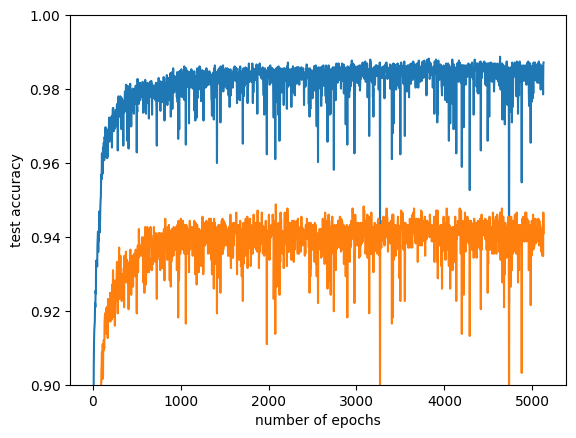

In [ ]:
plt.ylabel('test accuracy')
plt.xlabel('number of epochs')
plt.ylim([.9,1])

plt.plot(jnp.arange(1,3*len(acc_classif_train),3), acc_classif_train)
plt.plot(jnp.arange(1,3*len(acc_classif_test),3), acc_classif_test)

In [ ]:
np.max(acc_classif_train)

Array(0.9887523, dtype=float32)

In [ ]:
np.max(acc_classif_test)

Array(0.94880354, dtype=float32)

In [ ]:
np.savetxt("N2=none_accuracy_test.csv", acc_classif_test, delimiter=",")

In [ ]:
np.savetxt("N2=none_accuracy_training.csv", acc_classif_train, delimiter=",")

In [ ]:
np.savetxt("N2=none_costfunction.csv", prec, delimiter=",")